## Testando Prompt (usando classe nas tools)

### Tokens e imports

In [2]:
# default
import os
from getpass import getpass
import pandas as pd
from typing import Annotated
from typing_extensions import TypedDict

# langchain 
from langgraph.graph.message import add_messages
from langchain.agents import tool
from langgraph.graph import StateGraph, START, END, MessagesState
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.checkpoint.memory import MemorySaver
from langchain.tools.render import render_text_description

from langchain_community.chat_models import ChatDeepInfra
from langchain_community.tools.tavily_search import TavilySearchResults

from langchain_core.messages import HumanMessage, SystemMessage, AIMessage
from langchain_core.prompts import ChatPromptTemplate, PromptTemplate
from langchain_core.prompts import HumanMessagePromptTemplate

# from langchain_experimental.agents.agent_toolkits import create_pandas_dataframe_agent


from dotenv import load_dotenv


In [3]:
os.environ["DEEPINFRA_API_TOKEN"] = getpass("Digite sua chave da DeepInfra: ")

In [4]:

chat = ChatDeepInfra(model="deepseek-ai/DeepSeek-V3") 

In [5]:
os.environ["TAVILY_API_KEY"] = getpass("Digite sua chave do Travily: ")
#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

### Definindo Tools
Aqui definirei as tools do meu agente. Inicialmente tools simples e aleatórias apenas para testar

In [6]:
df_global = pd.read_csv("./datasets/pems03.csv")
print(f"DataFrame global carregado com {df_global.shape[0]} linhas e {df_global.shape[1]} colunas.")


@tool("get_column_names")
def get_column_names(state: dict) -> str:
    """
    Retorna uma lista com todos os nomes das colunas do dataset.
    Útil para saber quais colunas estão disponíveis para análise.
    """
    df = state['dataframe']
    return str(df.columns.tolist())

@tool("summary_statistics")
def summary_statistics(state: dict, column_name: str) -> str:
    """
    Calcula estatísticas descritivas para uma coluna numérica específica.
    Retorna média, desvio padrão, mínimo, máximo e os quartis.
    """
    df = state['dataframe']
    try:
        return df[column_name].describe().to_string()
    except KeyError:
        return f"Erro: A coluna '{column_name}' não existe. Colunas disponíveis: {df.columns.tolist()}"
    except TypeError:
        return f"Erro: A coluna '{column_name}' não parece ser numérica. Tente usar 'value_counts'."

@tool("value_counts")
def value_counts(state: dict, column_name: str) -> str:
    """
    Conta a frequência de cada valor único em uma coluna categórica.
    """
    df = state['dataframe']
    try:
        return df[column_name].value_counts().to_string()
    except KeyError:
        return f"Erro: A coluna '{column_name}' não existe. Colunas disponíveis: {df.columns.tolist()}"

@tool("check_missing_values")
def check_missing_values(state: dict, column_name: str) -> str:
    """
    Verifica e conta a quantidade de valores nulos (NaN) em uma coluna específica.
    """
    df = state['dataframe']
    try:
        missing_count = df[column_name].isnull().sum()
        return f"A coluna '{column_name}' tem {missing_count} valores faltantes."
    except KeyError:
        return f"Erro: A coluna '{column_name}' não existe. Colunas disponíveis: {df.columns.tolist()}"

@tool("calculate_correlation")
def calculate_correlation(state: dict, column_a: str, column_b: str) -> str:
    """
    Calcula a correlação entre duas colunas numéricas. O valor varia de -1 a 1.
    """
    df = state['dataframe']
    try:
        correlation = df[[column_a, column_b]].corr().iloc[0, 1]
        return f"A correlação entre '{column_a}' e '{column_b}' é: {correlation:.4f}"
    except KeyError as e:
        return f"Erro: Uma das colunas não existe. Coluna não encontrada: {e}. Colunas disponíveis: {df.columns.tolist()}"
    except TypeError:
        return f"Erro: Uma ou ambas as colunas não são numéricas. Não é possível calcular a correlação."


DataFrame global carregado com 26208 linhas e 359 colunas.


In [8]:
# ta faltando o 'tavily' nas tools, depois adiciono
tools = [get_column_names,
        summary_statistics,
        value_counts,
        check_missing_values,
        calculate_correlation]

In [9]:
chat_with_tools = chat.bind_tools(tools)

### Definições LangChain

In [20]:
# Definição do estado

class State(TypedDict):
    messages: Annotated[list, add_messages]
    dataframe_path: str
    # dataframe: pd.DataFrame

graph_builder = StateGraph(State)

In [21]:
# Definição de nós do grafo 

# NOVO NÓ para carregar os dados
def load_dataframe_node(state: State):
    """
    Carrega o DataFrame do caminho especificado no estado
    e o adiciona ao estado em memória.
    """
    df = pd.read_csv(state["dataframe_path"])
    print(f"DataFrame carregado dinamicamente com {df.shape[0]} linhas.")
    # Adiciona o dataframe carregado ao estado atual da execução
    return {"dataframe": df}

# Nó ja existente
def chatbot(state: State):
    return {"messages": [chat_with_tools.invoke(state["messages"])]}

tool_node = ToolNode(tools=tools)

# Adicionando os nós ao construtor do grafo
graph_builder.add_node("loader", load_dataframe_node)
graph_builder.add_node("chatbot", chatbot)
graph_builder.add_node("tools", tool_node)

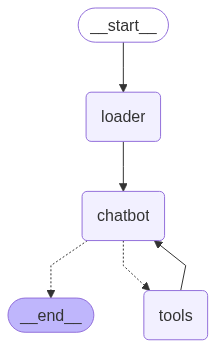

In [ ]:
# Criar o grafo

# O ponto de entrada agora é o nosso novo nó 'loader'
graph_builder.add_edge(START, "loader")

# Após carregar, o loader passa o controle para o chatbot
graph_builder.add_edge("loader", "chatbot")

graph_builder.add_conditional_edges("chatbot", tools_condition)
graph_builder.add_edge("tools", "chatbot")

checkpointer=MemorySaver()

config = {
    "configurable": {
        "api_key": "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",  # key da deepinfra ou 
        "model": "deepseek-ai/DeepSeek-V3",  # Your model
        "thread_id": "1"  # Optional conversation tracking
    }
}

graph = graph_builder.compile(checkpointer=checkpointer)

# from IPython.display import Image, display
# display(Image(graph.get_graph().draw_mermaid_png()))

### Agent Prompting
Essa é a parte que estou focando. Estou tentando usar "Iterative Refinement Prompting" & "Reasoning and Acting"

Possíveis melhorias: usar mais Identity Prompting (mais de uma persona pode ser bom); aprender "Meta Prompting";  aumentar o "Self-reflection Prompts"; usar LLM para gerar o "Iterative Refinement Prompting"


In [29]:

react_template = """
Você é um analista de dados especialista em Análise Exploratória de Dados (EDA), com foco principal em datasets de séries temporais. Sua tarefa é usar as ferramentas disponíveis para extrair insights valiosos e responder às perguntas do usuário, seguindo um ciclo rigoroso de raciocínio.

Você tem acesso às seguintes ferramentas:
{tools}

### REGRAS DE EXECUÇÃO
1.  **Ciclo de Análise**: Você deve decompor o problema em passos. Para cada passo, você gerará um **Pensamento** e uma **Ação**. Sua resposta DEVE parar após o JSON da Ação.
2.  **Análise da Observação**: Após sua ação, o sistema fornecerá uma **Observação**. Você DEVE analisar esta observação (seja um resultado ou um erro) para formular seu próximo Pensamento e Ação.
3.  **Simplicidade das Ferramentas**: As ferramentas são simples. Elas NÃO aceitam filtros ou lógicas complexas no `action_input`. Se uma tarefa requer múltiplos passos (como filtrar por data e depois contar), você DEVE usar ferramentas em passos separados.
4.  **Formato do Input**: O formato de `action_input` é CRÍTICO. Para ferramentas que pedem um nome de coluna (como `value_counts`), o input deve ser uma STRING SIMPLES (ex: `"Minha_Coluna"`), não um objeto JSON.

### EXEMPLO DE CICLO COMPLETO

Pergunta: Qual a distribuição da coluna 'Vendas_Totais'?
Pensamento: Não tenho certeza do nome exato da coluna. Vou primeiro verificar todos os nomes de colunas disponíveis para ter certeza.
Ação:
```json
{
    "action": "get_column_names",
    "action_input": {}
}
```
Observação: ['Timestamp', 'Vendas_Totais', 'Regiao', 'ID_Produto']
Pensamento: Agora vejo o nome correto da coluna é 'Vendas_Totais'. Vou chamar value_counts para obter a distribuição, usando o formato de string simples como a ferramenta requer.
Ação:
```json
{
    "action": "value_counts",
    "action_input": "Vendas_Totais"
}
```
Observação: [Resultado da ferramenta value_counts]
Pensamento: Agora tenho a informação que preciso para responder diretamente ao usuário.
Resposta Final: A distribuição da coluna 'Vendas_Totais' é a seguinte: [resultado do value_counts aqui]

SEU TURNO
Agora, siga o mesmo processo. Analise a pergunta e o histórico (Observações).

Se você precisar de mais informações, use este formato:
Pensamento: [Seu raciocínio sobre qual ferramenta usar e por quê]
Ação:
```json
{
"action": "nome da ferramenta",
"action_input": "entrada da ferramenta"
}
```
Se você já pode responder, use este formato:
Pensamento: [Seu raciocínio de que a informação é suficiente]
Resposta Final: [Sua resposta completa e bem formatada para o usuário]
"""

prompt_template = ChatPromptTemplate.from_messages(
                [
                    SystemMessage(content=react_template, input_variables=['tool_names', 'tools']),
                    HumanMessagePromptTemplate.from_template("{question}"),
                ]
            )


prompt = prompt_template.partial(
    tools=render_text_description(tools),
    tool_names=", ".join([t.name for t in tools]),
)


### Tentando conversar com o agente

In [30]:
# A invocação inicial agora inclui o dataframe
estado = graph.invoke(
    {
        "messages": prompt.format_messages(question="Quais são os nomes das colunas?"),
        "dataframe_path": "./datasets/pems03.csv"  # Passando o caminho 
    },
    config
)

DataFrame carregado dinamicamente com 26208 linhas.


In [31]:
estado["messages"]

[SystemMessage(content='\nVocê é um analista de dados especialista em Análise Exploratória de Dados (EDA), com foco principal em datasets de séries temporais. Sua tarefa é usar as ferramentas disponíveis para extrair insights valiosos e responder às perguntas do usuário, seguindo um ciclo rigoroso de raciocínio.\n\nVocê tem acesso às seguintes ferramentas:\n{tools}\n\n### REGRAS DE EXECUÇÃO\n1.  **Ciclo de Análise**: Você deve decompor o problema em passos. Para cada passo, você gerará um **Pensamento** e uma **Ação**. Sua resposta DEVE parar após o JSON da Ação.\n2.  **Análise da Observação**: Após sua ação, o sistema fornecerá uma **Observação**. Você DEVE analisar esta observação (seja um resultado ou um erro) para formular seu próximo Pensamento e Ação.\n3.  **Simplicidade das Ferramentas**: As ferramentas são simples. Elas NÃO aceitam filtros ou lógicas complexas no `action_input`. Se uma tarefa requer múltiplos passos (como filtrar por data e depois contar), você DEVE usar ferram